## Background

In this blog post I'll work through the third "Further Research" exercise from Chapter 9 of the fastai textbook:

> Use the embeddings from the neural net in this chapter in a random forest, and see if you can improve on the random forest results we saw.

I'll train a neural net on the dataset, grab its embeddings for categorical variables, replace the existing categorical variables in the dataset with them, and then train a random forest on that updated dataset.

The neural net in the chapter was trained on only a subset of columns (after removing columns that were redundant and low importance). I'll first go through the process of reducing the number of used columns with a random forest as done in the chapter text before training the neural net.

In addition to the textbook, I also heavily reference the code provided in [this medium post by Adam Mehdi](https://towardsdatascience.com/entity-embeddings-for-ml-2387eb68e49) a similar implementation of which was shared in [this fastai forum post (sign-in required)](https://forums.fast.ai/t/using-embedding-from-the-neural-network-in-random-forests/80063/10?u=vbakshi).

---

Here is a summary of error values for models fit on the original and embedding-filled datasets in this exercise:

|Model|Validation MSE|Reduction in MSE|
|:-|:-:|:-:|
|RF (no embedding columns)|0.247074|--|
|RF (329 embedding columns)|0.238825|3.33%|
|RF (32 embedding columns)|0.243094|1.6%|


## Load the Data

In [ ]:
!pip install dtreeviz

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [ ]:
from pathlib import Path

cred_path = Path("~/.kaggle/kaggle.json").expanduser()
if not cred_path.exists():
  cred_path.parent.mkdir(exist_ok=True)
  cred_path.write_text(creds)
  cred_path.chmod(0o600)

In [ ]:
import zipfile,kaggle

path = Path('bluebook-for-bulldozers')
if not path.exists():
  kaggle.api.competition_download_cli(str(path))
  zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 48.4M/48.4M [00:00<00:00, 65.2MB/s]


In [ ]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [ ]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,...,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,...,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,...,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,...,NaN,NaN,NaN,NaN


## Clean the Data

Categorize the `ProductSize` variable:

In [ ]:
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

Take the `log` of the dependent variable, `SalePrice`:

In [ ]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

Add date-related additional columns---I'll deviate from the textbook here and save the original `saledate` column so I can more accurately create the training and validation sets. I'll likely remove it later on when I remove redundant features.

In [ ]:
saledate = df.saledate
df = add_datepart(df, 'saledate')
df['saledate'] = saledate

In [ ]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed saledate'

## Create Training and Validation Sets

In [ ]:
procs = [Categorify, FillMissing]

I'll define a validation set consisting of data from after November 2011:

In [ ]:
df['saledate'] = pd.to_datetime(df['saledate'])

In [ ]:
df

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_end,saleIs_year_start,saleElapsed,saledate
0,1139246,11.097410,999089,3157,...,False,False,1.163635e+09,2006-11-16
1,1139248,10.950807,117657,77,...,False,False,1.080259e+09,2004-03-26
2,1139249,9.210340,434808,7009,...,False,False,1.077754e+09,2004-02-26
3,1139251,10.558414,1026470,332,...,False,False,1.305763e+09,2011-05-19
4,1139253,9.305651,1057373,17311,...,False,False,1.248307e+09,2009-07-23
...,...,...,...,...,...,...,...,...,...
412693,6333344,9.210340,1919201,21435,...,False,False,1.331078e+09,2012-03-07
412694,6333345,9.259131,1882122,21436,...,False,False,1.327709e+09,2012-01-28
412695,6333347,9.433484,1944213,21435,...,False,False,1.327709e+09,2012-01-28
412696,6333348,9.210340,1794518,21435,...,False,False,1.331078e+09,2012-03-07


In [ ]:
df['saledate'] < '2011-11-01'

0          True
1          True
2          True
3          True
4          True
          ...  
412693    False
412694    False
412695    False
412696    False
412697    False
Name: saledate, Length: 412698, dtype: bool

In [ ]:
cond = df['saledate'] < '2011-11-01'
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]
splits = (list(train_idx), list(valid_idx))

In [ ]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [ ]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [ ]:
len(to.train), len(to.valid)

(395371, 17327)

In [ ]:
xs,y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

## Removing Features

To simplify our model, and in some cases improve the accuracy, I will follow the procedure in the textbook to reduce the number of features we use for training.

In [10]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [84]:
def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):
  return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples, max_features=max_features, min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs,y)

In [85]:
def rf_feat_importance(m, df):
  return pd.DataFrame({
      'cols': df.columns,
      'imp': m.feature_importances_}
                      ).sort_values('imp', ascending=False)

I'll start by fitting a random forest to the data and establishing a baseline MSE on the validation set to use in comparison at each step of reducing features.

In [ ]:
m = rf(xs, y);
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.169314, 0.29212)

### Low-Importance Features

Next, I'll take a look at the most important features and remove low-importance features from the dataset.

In [ ]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
58,YearMade,0.182072
6,ProductSize,0.114709
30,Coupler_System,0.104344
7,fiProductClassDesc,0.064090
55,ModelID,0.057407
31,Grouser_Tracks,0.047770
3,fiSecondaryDesc,0.042480
10,ProductGroupDesc,0.038196
32,Hydraulics_Flow,0.034735
50,saledate,0.033807


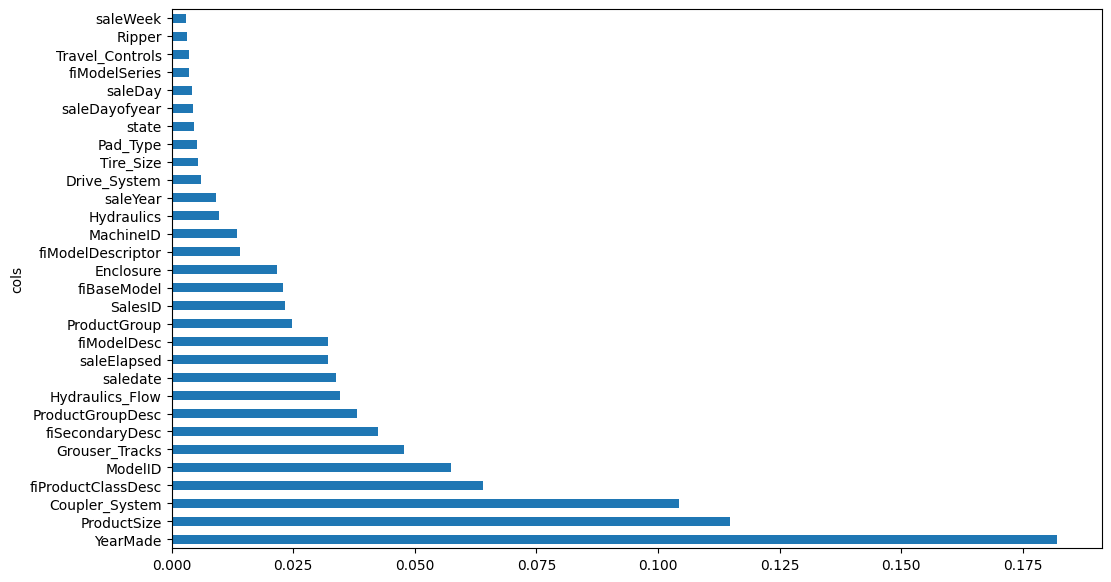

In [ ]:
def plot_fi(fi):
  return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [ ]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

23

In [ ]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

I'll check the accuracy on the validation set with the low-importance features removed:

In [ ]:
m = rf(xs_imp, y);
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.178435, 0.284805)

Our model is much simpler (fewer features to analyze) with a similar error as before.

In [ ]:
len(xs.columns), len(xs_imp.columns)

(67, 23)

### Redundant Features

Next, I'll take a look at which features are redundant and try to remove some of them (as long as they don't diminish the model's OOB score):

In [98]:
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

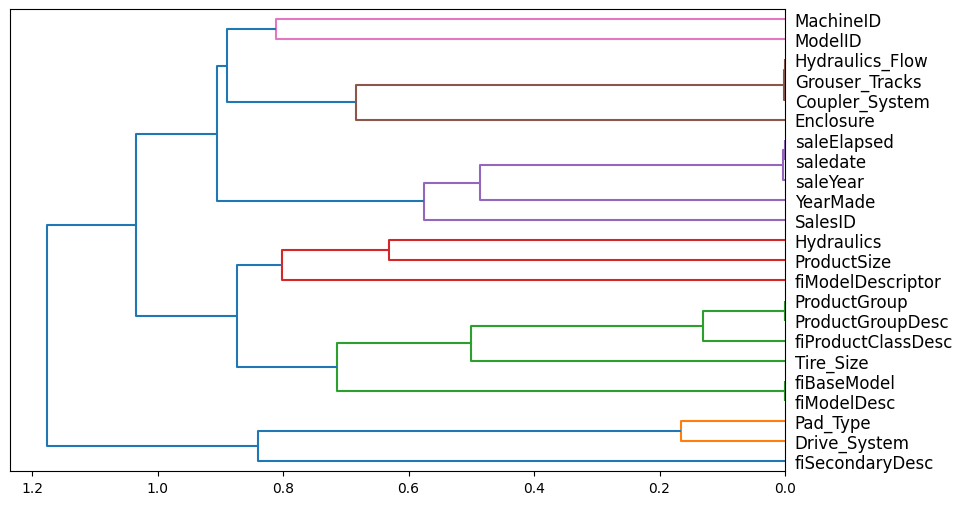

In [ ]:
cluster_columns(xs_imp)

In [101]:
def get_oob(df):
  m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
                            max_samples=50_000, max_features=0.5, n_jobs=-1, oob_score=True)
  m.fit(df, y)
  return m.oob_score_

Here's the baseline OOB score for the dataset with only high-importance variables:

In [ ]:
get_oob(xs_imp)

0.8775680670271139

Here are the OOB scores if we drop redundant features from the dataset---the higher the OOB score the better:

In [ ]:
{c: get_oob(xs_imp.drop(c, axis=1)) for c in (
    'Hydraulics_Flow', 'Grouser_Tracks', 'Coupler_System',
    'saleElapsed', 'saledate', 'saleYear',
    'ProductGroup', 'ProductGroupDesc',
    'fiBaseModel', 'fiModelDesc')}

{'Hydraulics_Flow': 0.8784714680954607,
 'Grouser_Tracks': 0.8781347745872132,
 'Coupler_System': 0.8782757080902821,
 'saleElapsed': 0.8780747364566069,
 'saledate': 0.8775743905455275,
 'saleYear': 0.8777160634533703,
 'ProductGroup': 0.8777345710442639,
 'ProductGroupDesc': 0.8785070588073342,
 'fiBaseModel': 0.8775911401001298,
 'fiModelDesc': 0.8764381706728157}

I'll select the variable from each redundant group, the removal of which increased the OOB score (or kept it the same) and remove it from the dataset:

In [ ]:
to_drop = ['Hydraulics_Flow', 'saleElapsed', 'ProductGroupDesc', 'fiBaseModel']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8759470650709008

In [ ]:
0.8759470650709008/0.8775680670271139

0.9981528476056514

The OOB score slightly decreased, but now we have fewer redundant features in the dataset.

In [ ]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [ ]:
# check error
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.181023, 0.37027)

The validation error is more than twice the training error and has considerably increased from previous datasets. I'll see if removing out-of-domain features improves the error.

### Out-of-Domain Features

I'll remove columns from the training set that are out-of-domain (i.e., significantly different in values from) in the validation set. I'll identify these columns by fitting a random forest to predict whether a row is in the training or validation set and then observing the most important features in this prediction:

In [ ]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
7,saledate,0.704401
15,saleYear,0.215157
10,SalesID,0.075075
13,MachineID,0.003997
0,YearMade,0.000683
4,ModelID,0.000228


The most important feature in predicting whether a row is in the training or validation set is the `saledate` feature. This makes sense because I explicitly define the training and validation sets based on `saledate`. The next two features of high importance are `saleYear` and `SalesID` which also are related to when the sale occured.

In [ ]:
# baseline
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('saledate', 'saleYear', 'SalesID'):
  m = rf(xs_final.drop(c, axis=1), y)
  print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.365206
saledate 0.246061
saleYear 0.437766
SalesID 0.402223


Removing `saledate` reduces the error by a third!

In [ ]:
xs_final_time = xs_final.drop('saledate', axis=1)
valid_xs_time = valid_xs_final.drop('saledate', axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

In [ ]:
m_rmse(m, xs_final_time, y), m_rmse(m, valid_xs_time, valid_y)

(0.189063, 0.247074)

In [ ]:
len(xs_final_time.columns)

18

The validation error is still larger than the training error but removing `saledate` has reduced the validation error considerably, even when compared to the original dataset and the dataset after only low-importance features were removed. I consider this process of feature removal successful.

## Train a Neural Net

I'll re-load the data and apply the same feature engineering as before:

In [ ]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [ ]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [ ]:
len(df_nn_final.columns)

19

I'll split the columns into continuous and categorical groups:

In [ ]:
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

I'll look at the cardinality of the categorical variables and see if there are any variables that have similarly large cardinality (as those would be candidates for removal). I also want to look at cardinality so I can later on identify which embeddings belong to which categorical variables.

In [ ]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
Grouser_Tracks           2
fiSecondaryDesc        177
fiModelDesc           5059
ProductGroup             6
Enclosure                6
fiModelDescriptor      140
Hydraulics              12
saleYear                24
Drive_System             4
Tire_Size               17
Pad_Type                 4
dtype: int64

The two features with similar high cardinality are `ModelID` and `fiModelDesc`. I'll remove and see which one improves the model more.

In [ ]:
xs_final_time2 = xs_final_time.drop('ModelID', axis=1)
valid_xs_time2 = valid_xs_time.drop('ModelID', axis=1)
m2 = rf(xs_final_time2, y)
m_rmse(m2, xs_final_time2, y), m_rmse(m2, valid_xs_time2, valid_y)

(0.190922, 0.250589)

In [ ]:
xs_final_time2 = xs_final_time.drop('fiModelDesc', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDesc', axis=1)
m2 = rf(xs_final_time2, y)
m_rmse(m2, xs_final_time2, y), m_rmse(m2, valid_xs_time2, valid_y)

(0.192338, 0.251594)

Removing `ModelID` gives a smaller error than removing `fiModelDesc`. Also, we want to predict future auction sales so I'll move `saleYear` to `cont_nn` (as categorical values cannot be extrapolated beyond their existing levels).

In [ ]:
cat_nn.remove('ModelID')
cat_nn.remove('saleYear')
cont_nn.append('saleYear')

In [ ]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
Grouser_Tracks           2
fiSecondaryDesc        177
fiModelDesc           5059
ProductGroup             6
Enclosure                6
fiModelDescriptor      140
Hydraulics              12
Drive_System             4
Tire_Size               17
Pad_Type                 4
dtype: int64

In [ ]:
cont_nn

['SalesID', 'MachineID', 'saleYear']

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var)

In [ ]:
# save for later
data = (xs_final_time, y, valid_xs_time, valid_y)
save_pickle("to_nn.pkl", to_nn)
save_pickle("data.pkl", data)

In [4]:
# load objects
to_nn = load_pickle("to_nn.pkl")
xs_final_time, y, valid_xs_time, valid_y = load_pickle("data.pkl")

In [5]:
dls = to_nn.dataloaders(1024)

In [6]:
# set y-range
y = to_nn.train.y
y.min(), y.max()

(8.465899, 11.863583)

SuggestedLRs(valley=0.00013182566908653826)

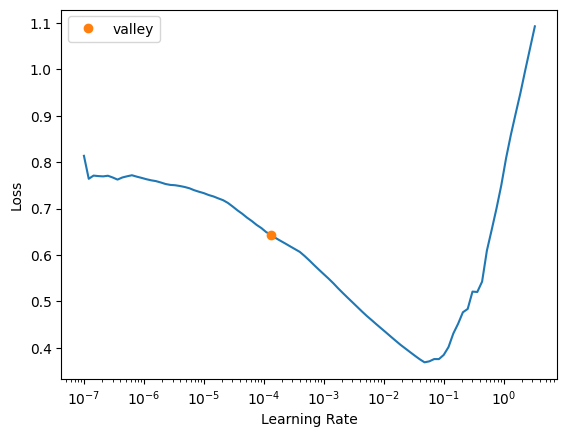

In [7]:
from fastai.tabular.all import *
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

learn.lr_find()

In [8]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.066889,0.173385,00:30
1,0.055220,0.071100,00:27
2,0.050529,0.059935,00:30
3,0.045348,0.058667,00:27
4,0.041716,0.058603,00:27


In [11]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

0.242081

## Neural Net Embeddings

Now that the model is trained, let's take a look at the embeddings that it created. The first dimension of each embedding roughly corresponds to the number of unique values in the corresponding categorical column:

In [12]:
learn.model.embeds

ModuleList(
  (0): Embedding(72, 18)
  (1): Embedding(7, 5)
  (2): Embedding(3, 3)
  (3): Embedding(75, 18)
  (4): Embedding(3, 3)
  (5): Embedding(178, 29)
  (6): Embedding(5060, 190)
  (7-8): 2 x Embedding(7, 5)
  (9): Embedding(141, 26)
  (10): Embedding(13, 7)
  (11): Embedding(5, 4)
  (12): Embedding(18, 8)
  (13): Embedding(5, 4)
)

In [ ]:
to_nn.train.xs[to_nn.cat_names].nunique()

YearMade                71
ProductSize              7
Coupler_System           3
fiProductClassDesc      74
Grouser_Tracks           3
fiSecondaryDesc        176
fiModelDesc           4965
ProductGroup             6
Enclosure                7
fiModelDescriptor      140
Hydraulics              13
Drive_System             5
Tire_Size               18
Pad_Type                 5
dtype: int64

In [this medium blog post](https://towardsdatascience.com/entity-embeddings-for-ml-2387eb68e49#:~:text=2.%20Replace%20each%20categorical%20value%20with%20its%20embedding%20vector) Adam Mehdi uses the following code to replace categorical columns in the training set with embedding matrices:

```python
def embed_features(learner, xs):
  """
  learner: fastai Learner used to train the neural net
  xs: DataFrame containing input variables. Categorical values are defined by their rank.
 ::return:: copy of `xs` with embeddings replacing each categorical variable
  """
  xs = xs.copy()
  for i,col in enumerate(learn.dls.cat_names):
    
    # get matrix containing each row's embedding vector
    emb = learn.model.embeds[i]
    emb_data = emb(tensor(xs[col], dtype=torch.int64))
    emb_names = [f'{col}_{j}' for j in range(emb_data.shape[1])]
    
    # join the embedded category and drop the old feature column
    feat_df = pd.DataFrame(data=emb_data, index=xs.index,               
                           columns=emb_names)
    xs = xs.drop(col, axis=1)
    xs = xs.join(feat_df)
  return xs
```

I'll work through the code line-by-line for one of the categorical columns, `ProductSize`. First we grab the column's corresponding `Embedding` from the model:

In [20]:
emb = learn.model.embeds[1]
emb

Embedding(7, 5)

I then pass all `ProductSize` values to that `Embedding` as an integer tensor. The output is a matrix with one row for each training observation, and 5 columns (chosen by the model for `ProductSize`):

In [22]:
emb_data = emb(tensor(xs_final_time['ProductSize'], dtype=torch.int64))
emb_data.shape

torch.Size([395371, 5])

In [23]:
len(xs_final_time)

395371

To appropriately name the columns in the updated dataset, I label the embedding layer names as done in the medium post:

In [26]:
emb_names = [f'ProductSize_{j}' for j in range(emb_data.shape[1])]
emb_names

['ProductSize_0',
 'ProductSize_1',
 'ProductSize_2',
 'ProductSize_3',
 'ProductSize_4']

I then convert the 2-D tensor to a `DataFrame`:

In [28]:
feat_df = pd.DataFrame(
    data=emb_data,
    index=xs_final_time.index,
    columns=emb_names)

feat_df.head()

,ProductSize_0,ProductSize_1,ProductSize_2,ProductSize_3,ProductSize_4
0,-0.003886,0.204614,-0.099826,0.152207,0.215685
1,-0.114329,-0.100198,-0.071906,-0.128801,-0.039516
2,-0.003886,0.204614,-0.099826,0.152207,0.215685
3,-0.005051,0.042276,-0.102471,0.016768,0.001030
4,-0.003886,0.204614,-0.099826,0.152207,0.215685


Finally, I drop the `ProductSize` column from the dataset and replace it with my embedding `DataFrame`:

In [29]:
xs_temp = xs_final_time.drop('ProductSize', axis=1)
xs_temp = xs_temp.join(feat_df)
xs_temp.columns

Index(['YearMade', 'Coupler_System', 'fiProductClassDesc', 'ModelID',
       'Grouser_Tracks', 'fiSecondaryDesc', 'fiModelDesc', 'ProductGroup',
       'SalesID', 'Enclosure', 'fiModelDescriptor', 'MachineID', 'Hydraulics',
       'saleYear', 'Drive_System', 'Tire_Size', 'Pad_Type', 'ProductSize_0',
       'ProductSize_1', 'ProductSize_2', 'ProductSize_3', 'ProductSize_4'],
      dtype='object')

With a single iteration done successfully, now I can run the whole loop and get the updated dataset with embedding matrices:

In [53]:
def embed_features(learn, xs):
  xs = xs.copy()

  for i, col in enumerate(learn.dls.cat_names):
    emb = learn.model.embeds[i]
    emb_data = emb(tensor(xs[col], dtype=torch.int64))
    emb_names = [f'{col}_{j}' for j in range(emb_data.shape[1])]

    feat_df = pd.DataFrame(
        data=emb_data,
        index=xs.index,
        columns=emb_names
    )

    xs = xs.drop(col, axis=1)
    xs = xs.join(feat_df)
  return xs

One bit of preprocessing I'll have to do is swap the categorical columns in `xs_final_time` with the ones in `to_nn.train.xs` since the latter has been "categorified" by the `Categorify` fastai processor into 0 to n integer values. To illustrate: the first value of the `YearMade` column in `xs_final_time` is `2004` whereas it's converted to the integer `63` in the corresponding `to_nn.train.xs` column. The embedding corresponding to this column has a dimension of `72` so it can take a maximum value of `71` as the input, which is the maximum value in `to_nn.train.xs['YearMade']`.

In [48]:
xs_final_time['YearMade'][0]

2004

In [49]:
to_nn.train.xs['YearMade'][0]

63

In [52]:
learn.model.embeds[0]

Embedding(72, 18)

In [51]:
to_nn.train.xs['YearMade'].max()

71

Here's a bit of code to swap the columns:

In [73]:
def prep_xs(to_nn, xs):
  xs = xs.copy()
  for col in to_nn.train.xs.columns:
    xs[col] = to_nn[col]
  return xs

In [74]:
xs_with_embs = prep_xs(to_nn, xs_final_time)
xs_with_embs['YearMade'].unique()

array([63, 55, 60, 66, 52, 67,  1, 57, 58, 62, 50, 59, 64, 54, 65, 61, 43,
       47, 39, 51, 46, 56, 30, 37, 48, 44, 38, 35, 53, 41, 49, 33, 27, 25,
       42, 45, 40, 29, 36, 34, 32, 24, 26, 68, 69, 28, 31, 23, 16, 17, 22,
        2,  3,  9,  7, 11,  5, 15, 13, 12, 14, 18, 19, 20, 21, 10,  4,  8,
        6, 71, 70], dtype=int8)

Now that I have categorified the categorical columns the embeddings are trained on, I can process to swap them with embedding matrices:

In [75]:
xs_with_embs = embed_features(learn, xs_with_embs)
xs_with_embs.columns

Index(['ModelID', 'SalesID', 'MachineID', 'saleYear', 'YearMade_0',
       'YearMade_1', 'YearMade_2', 'YearMade_3', 'YearMade_4', 'YearMade_5',
       ...
       'Tire_Size_2', 'Tire_Size_3', 'Tire_Size_4', 'Tire_Size_5',
       'Tire_Size_6', 'Tire_Size_7', 'Pad_Type_0', 'Pad_Type_1', 'Pad_Type_2',
       'Pad_Type_3'],
      dtype='object', length=329)

I'll check to see that the number of columns corresponding to the embedding matches the number of columns in the second dimension of the embedding matrix:

In [76]:
learn.model.embeds[0]

Embedding(72, 18)

In [77]:
' '.join(o for o in xs_with_embs.columns if o.startswith('YearMade'))

'YearMade_0 YearMade_1 YearMade_2 YearMade_3 YearMade_4 YearMade_5 YearMade_6 YearMade_7 YearMade_8 YearMade_9 YearMade_10 YearMade_11 YearMade_12 YearMade_13 YearMade_14 YearMade_15 YearMade_16 YearMade_17'

In [78]:
learn.model.embeds[1]

Embedding(7, 5)

In [79]:
' '.join(o for o in xs_with_embs.columns if o.startswith('ProductSize'))

'ProductSize_0 ProductSize_1 ProductSize_2 ProductSize_3 ProductSize_4'

I'll make the same changes to the validation set:

In [80]:
valid_xs_with_embs = prep_xs(to_nn, valid_xs_time)
valid_xs_with_embs['YearMade'].unique()

array([ 1, 63, 61, 66, 68, 64, 60, 57, 58, 65, 67, 59, 48, 62, 56, 40, 44,
       49, 55, 34, 35, 39, 54, 42, 41, 23, 45, 38, 43, 52, 47, 51, 53, 50,
       33, 37, 36, 46, 27, 30, 28, 32, 25, 31, 24, 15, 22, 29, 21, 26,  0,
       70, 69, 17, 16, 12], dtype=int8)

In [81]:
valid_xs_with_embs = embed_features(learn, valid_xs_with_embs)
valid_xs_with_embs.columns

Index(['ModelID', 'SalesID', 'MachineID', 'saleYear', 'YearMade_0',
       'YearMade_1', 'YearMade_2', 'YearMade_3', 'YearMade_4', 'YearMade_5',
       ...
       'Tire_Size_2', 'Tire_Size_3', 'Tire_Size_4', 'Tire_Size_5',
       'Tire_Size_6', 'Tire_Size_7', 'Pad_Type_0', 'Pad_Type_1', 'Pad_Type_2',
       'Pad_Type_3'],
      dtype='object', length=329)

In [82]:
' '.join(o for o in valid_xs_with_embs.columns if o.startswith('YearMade'))

'YearMade_0 YearMade_1 YearMade_2 YearMade_3 YearMade_4 YearMade_5 YearMade_6 YearMade_7 YearMade_8 YearMade_9 YearMade_10 YearMade_11 YearMade_12 YearMade_13 YearMade_14 YearMade_15 YearMade_16 YearMade_17'

In [83]:
' '.join(o for o in valid_xs_with_embs.columns if o.startswith('ProductSize'))

'ProductSize_0 ProductSize_1 ProductSize_2 ProductSize_3 ProductSize_4'

Looks good! Now I can go on to fit a random forest on this embedding-filled dataset.

## Fitting a Random Forest

In [86]:
m = rf(xs_with_embs, y);
m_rmse(m, xs_with_embs, y), m_rmse(m, valid_xs_with_embs, valid_y)

(0.178098, 0.238825)

The previous random forest, with low-importance, redundant and out-of-domain features removed had training and validation errors of `0.189063` and `0.247074`, respectively. This model has lower errors for both.

### Removing Features

Next, I'll look into removing features from this updated dataset that has embedding matrices in it. Currently my training dataset has 300+ columns in it.

In [88]:
xs_with_embs.shape

(395371, 329)

#### Low-Importance Features

Here are the top-10 features in my model---all except one of the top 10 features are outputs from the categorical embeddings.

In [89]:
fi = rf_feat_importance(m, xs_with_embs)
fi[:10]

,cols,imp
37,fiProductClassDesc_7,0.117214
263,fiModelDesc_183,0.099233
3,saleYear,0.063399
36,fiProductClassDesc_6,0.062105
209,fiModelDesc_129,0.050837
208,fiModelDesc_128,0.037791
43,fiProductClassDesc_13,0.033951
181,fiModelDesc_101,0.027102
152,fiModelDesc_72,0.017599
100,fiModelDesc_20,0.017077


And here's a plot of the top 30 most important features:

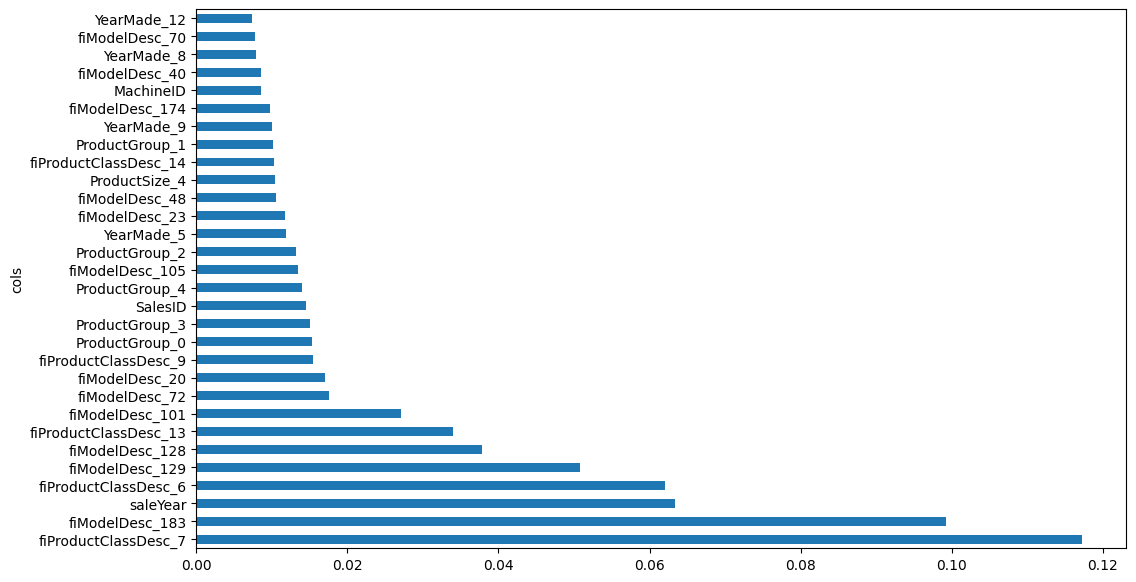

In [90]:
def plot_fi(fi):
  return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Like last time, I'll only keep features that have an importance of 0.005 or greater---which results in keeping only about 10% of the columns:

In [91]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

36

In [94]:
xs_imp_embs = xs_with_embs[to_keep]
valid_xs_imp_embs = valid_xs_with_embs[to_keep]

In [95]:
xs_imp_embs.shape, valid_xs_imp_embs.shape

((395371, 36), (17327, 36))

In [96]:
m = rf(xs_imp_embs, y);
m_rmse(m, xs_imp_embs, y), m_rmse(m, valid_xs_imp_embs, valid_y)

(0.184552, 0.242728)

The errors are higher than when all columns were included, but lower than when the original categorical columns were included.

#### Redundant Features

Similar to before, I'll see if I can remove any redundant features from the dataset to continue simplifying the model.

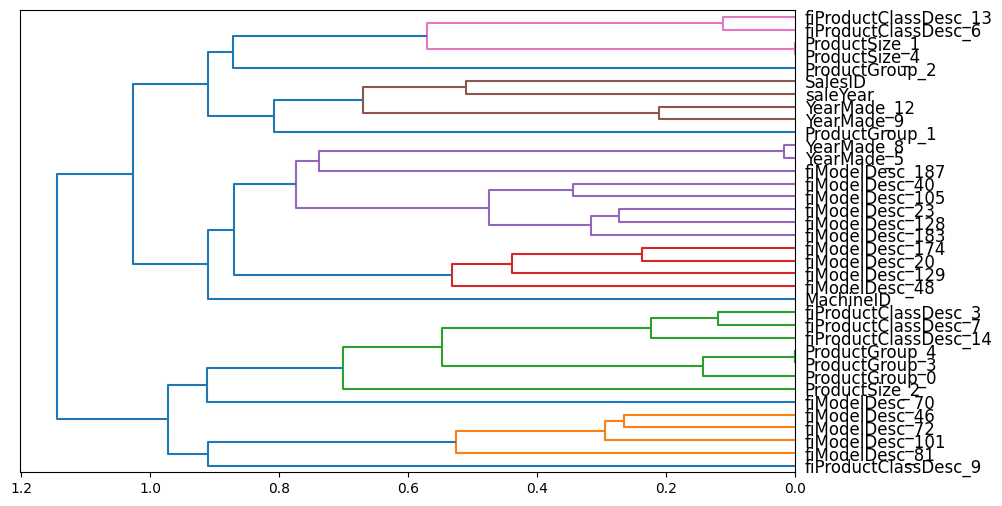

In [100]:
cluster_columns(xs_imp_embs)

I was expecting more columns to be redundant, since the columns in a categorical embedding matrix are related to the same column. However, it's interesting to note that different embedding matrix columns for a categorical variable represent different aspects of that feature.

As before, I'll calculate a baseline OOB score, and then use it to compare with scores after redundant features are removed:

In [102]:
get_oob(xs_imp_embs)

0.8892042378420308

Here are the OOB scores if I drop each individual redundant feature from the dataset:

In [103]:
{c: get_oob(xs_imp_embs.drop(c, axis=1)) for c in (
    'ProductSize_1', 'ProductSize_4',
    'YearMade_8', 'YearMade_5',
    'ProductGroup_4', 'ProductGroup_3')}

{'ProductSize_1': 0.8885392743641873,
 'ProductSize_4': 0.8890680891755572,
 'YearMade_8': 0.8885895030231491,
 'YearMade_5': 0.8884153739148248,
 'ProductGroup_4': 0.8890909768453596,
 'ProductGroup_3': 0.8890208894539288}

I'll remove the three columns, the removal of which keeps the first three decimal places of the OOB score the same.

In [104]:
to_drop = ['ProductSize_4', 'ProductGroup_4', 'ProductGroup_3']
get_oob(xs_imp_embs.drop(to_drop, axis=1))

0.8890859448391993

In [105]:
xs_embs_final = xs_imp_embs.drop(to_drop, axis=1)
valid_xs_embs_final = valid_xs_imp_embs.drop(to_drop, axis=1)

In [106]:
m = rf(xs_embs_final, y)
m_rmse(m, xs_embs_final, y), m_rmse(m, valid_xs_embs_final, valid_y)

(0.184845, 0.244098)

The errors have slightly increased but are still lower than the model fitted to the original dataset.

#### Out-of-Domain Features

The final set of features I'll look to remove are those that have significantly different values between the training and validation sets. As I did before, I'll fit a random forest to predict whether a row is from the training or validation set, and then look at the most important features for this distinction:

In [107]:
df_dom = pd.concat([xs_embs_final, valid_xs_embs_final])
is_valid = np.array([0]*len(xs_embs_final) + [1]*len(valid_xs_embs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
2,saleYear,0.567392
12,SalesID,0.266997
22,MachineID,0.072159
26,YearMade_12,0.006785
15,YearMade_5,0.004990
24,YearMade_8,0.004247


The three most important features in distinguishing a training set row from a validation set row are `saleYear`, `SalesID`, and `MachineID`. This is similar to what we experienced before---these are all time-influenced features and the training and validation set is split based on the sale date. I'll remove each one and see if it decreases the error of the model:

In [108]:
# baseline
m = rf(xs_embs_final, y)
print('orig', m_rmse(m, valid_xs_embs_final, valid_y))

for c in ('saleYear', 'SalesID', 'MachineID'):
  m = rf(xs_embs_final.drop(c, axis=1), y)
  print(c, m_rmse(m, valid_xs_embs_final.drop(c,axis=1), valid_y))

orig 0.243168
saleYear 0.248063
SalesID 0.243861
MachineID 0.243165


It looks like I can remove `MachineID` with only a tiny increase in the error.

In [ ]:
time_vars = ['MachineID']
xs_embs_final_time = xs_embs_final.drop(time_vars, axis=1)
valid_xs_embs_time = valid_xs_embs_final.drop(time_vars, axis=1)

m = rf(xs_embs_final_time, y)

In [111]:
m_rmse(m, xs_embs_final_time, y), m_rmse(m, valid_xs_embs_time, valid_y)

(0.189369, 0.243094)

In [117]:
# save for later
embs_xs = xs_embs_final_time, valid_xs_embs_time
save_pickle('embs_xs.pkl', embs_xs)

After removing features, the errors on the training and validation sets are a tiny bit smaller than the errors on the original datasets.

## Final Thoughts

Here is a summary of error values for models fit on the original and embedding-filled datasets:

|Model|Validation Error|Reduction in Error|
|:-|:-:|:-:|
|RF (no embedding columns)|0.247074|--|
|RF (329 embedding columns)|0.238825|3.33%|
|RF (30 embedding columns)|0.243094|1.6%|

To be honest I'm surprised that swapping categorical variables with neural net embeddings only reduced the validation MSE by 3.3%. I'm not sure what explains this small reduction. Maybe there's something about this dataset that doesn't benefit from converting categorical variables to embeddings? There's always a chance that my implementation is incorrect, or not the best way to achieve benefits in the model. As I practice working with more tabular datasets, I'll continue to implement neural net embeddings and observe if it makes a difference in how the model performs.

I hope you enjoyed this blog post!